In [1]:
import json
import re
import os
import tinker
from dotenv import load_dotenv

In [2]:
load_dotenv()
service_client = tinker.ServiceClient()
print("Available models:")
for item in service_client.get_server_capabilities().supported_models:
    print("- " + item.model_name)

Available models:
- deepseek-ai/DeepSeek-V3.1
- deepseek-ai/DeepSeek-V3.1-Base
- meta-llama/Llama-3.1-70B
- meta-llama/Llama-3.1-8B
- meta-llama/Llama-3.1-8B-Instruct
- meta-llama/Llama-3.2-1B
- meta-llama/Llama-3.2-3B
- meta-llama/Llama-3.3-70B-Instruct
- Qwen/Qwen3-235B-A22B-Instruct-2507
- Qwen/Qwen3-30B-A3B
- Qwen/Qwen3-30B-A3B-Base
- Qwen/Qwen3-30B-A3B-Instruct-2507
- Qwen/Qwen3-32B
- Qwen/Qwen3-4B-Instruct-2507
- Qwen/Qwen3-8B
- Qwen/Qwen3-8B-Base
- openai/gpt-oss-120b
- openai/gpt-oss-20b


In [19]:
# ========================================
# CONFIGURATION PARAMETERS
# ========================================

# Path to your full dataset
DATASET_PATH = "/Users/abhinavsattiraju/Desktop/329x/cs329x/data/dpo_informational_creative_split_lamini_version/final_lamini_informational_creative_dataset"

# Bucket configuration (alpha intervals)
BUCKET_INTERVAL = 0.2  # Change this to 0.1, 0.25, etc. for different granularity
# Will create buckets: [0.0, INTERVAL], [INTERVAL, 2*INTERVAL], ..., up to 1.0

# Sampling configuration
SAMPLES_PER_BUCKET = 100  # Number of prompts to sample from each bucket
RANDOM_SEED = 42  # For reproducibility

# ========================================
# LOAD AND PROCESS DATA
# ========================================

import pandas as pd
import numpy as np
from datasets import load_from_disk

# Load the full dataset
print("Loading dataset...")
full_dataset = load_from_disk(DATASET_PATH)
df = full_dataset.to_pandas()

print(f"✅ Loaded {len(df)} total examples")
print(f"α (creative_score) range: [{df['creative_score'].min():.3f}, {df['creative_score'].max():.3f}]")
print()

# ========================================
# CREATE BUCKETS
# ========================================

# Generate bucket edges based on interval
bucket_edges = np.arange(0.0, 1.0 + BUCKET_INTERVAL, BUCKET_INTERVAL)
bucket_edges = np.clip(bucket_edges, 0.0, 1.0)  # Ensure we don't exceed 1.0

print(f"Bucket edges: {bucket_edges}")
print()

# Create buckets using alpha (creative_score)
df['alpha'] = df['creative_score']  # Rename for clarity
df['bucket'] = pd.cut(
    df['alpha'], 
    bins=bucket_edges, 
    include_lowest=True,
    right=True  # Intervals are (a, b]
)

# ========================================
# ANALYZE BUCKET DISTRIBUTION
# ========================================

print("=" * 60)
print("BUCKET DISTRIBUTION")
print("=" * 60)

bucket_counts = df['bucket'].value_counts().sort_index()

for bucket, count in bucket_counts.items():
    print(f"{bucket}: {count:>5} prompts")

print("=" * 60)
print()

# ========================================
# SAMPLE FROM EACH BUCKET
# ========================================

print("=" * 60)
print(f"SAMPLING {SAMPLES_PER_BUCKET} PROMPTS PER BUCKET")
print("=" * 60)

sampled_data = {}
sampling_summary = []

for bucket in bucket_counts.index:
    bucket_df = df[df['bucket'] == bucket]
    available = len(bucket_df)
    
    # Sample up to SAMPLES_PER_BUCKET (or all if less available)
    n_sample = min(SAMPLES_PER_BUCKET, available)
    sampled = bucket_df.sample(n=n_sample, random_state=RANDOM_SEED)
    
    sampled_data[str(bucket)] = sampled
    
    print(f"{bucket}: sampled {n_sample:>3} / {available:>5} available")
    sampling_summary.append({
        'bucket': str(bucket),
        'available': available,
        'sampled': n_sample,
        'alpha_mean': bucket_df['alpha'].mean(),
        'alpha_std': bucket_df['alpha'].std()
    })

print("=" * 60)
print()

# ========================================
# SUMMARY STATISTICS
# ========================================

print("=" * 60)
print("SUMMARY STATISTICS PER BUCKET")
print("=" * 60)

summary_df = pd.DataFrame(sampling_summary)
print(summary_df.to_string(index=False))
print()

# ========================================
# COMBINED SAMPLED DATASET
# ========================================

# Combine all sampled data into one dataframe
all_sampled = pd.concat(sampled_data.values(), ignore_index=True)

print("=" * 60)
print(f"TOTAL SAMPLED: {len(all_sampled)} prompts")
print("=" * 60)
print()

# ========================================
# EXPORT (Optional)
# ========================================

# Access sampled prompts for each bucket
# Example: Get prompts from bucket [0.8, 1.0]
# bucket_key = "(0.8, 1.0]"  # Adjust based on your interval
# prompts = sampled_data[bucket_key]['input'].tolist()

print("✅ Data bucketized and sampled!")
print("\nAccess sampled data:")
print("  - sampled_data[bucket_name]: DataFrame for specific bucket")
print("  - all_sampled: Combined DataFrame with all samples")

Loading dataset...
✅ Loaded 18374 total examples
α (creative_score) range: [0.004, 0.969]

Bucket edges: [0.  0.2 0.4 0.6 0.8 1. ]

BUCKET DISTRIBUTION
(-0.001, 0.2]:  3109 prompts
(0.2, 0.4]:  5092 prompts
(0.4, 0.6]:  4855 prompts
(0.6, 0.8]:  3807 prompts
(0.8, 1.0]:  1511 prompts

SAMPLING 100 PROMPTS PER BUCKET
(-0.001, 0.2]: sampled 100 /  3109 available
(0.2, 0.4]: sampled 100 /  5092 available
(0.4, 0.6]: sampled 100 /  4855 available
(0.6, 0.8]: sampled 100 /  3807 available
(0.8, 1.0]: sampled 100 /  1511 available

SUMMARY STATISTICS PER BUCKET
       bucket  available  sampled  alpha_mean  alpha_std
(-0.001, 0.2]       3109      100    0.128139   0.046945
   (0.2, 0.4]       5092      100    0.301032   0.057708
   (0.4, 0.6]       4855      100    0.499083   0.058084
   (0.6, 0.8]       3807      100    0.694724   0.057504
   (0.8, 1.0]       1511      100    0.860560   0.039749

TOTAL SAMPLED: 500 prompts

✅ Data bucketized and sampled!

Access sampled data:
  - sampled_da

In [23]:
# ========================================
# SAVE SAMPLED DATA
# ========================================

import pickle

# Save sampled_data dictionary to pickle file
output_file = "sampled_data.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(sampled_data, f)

print(f"💾 Saved sampled_data to {output_file}")


💾 Saved sampled_data to sampled_data.pkl


In [1]:
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
from nltk import ngrams
from collections import Counter

# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

In [2]:
# ========================================
# SELF-BLEU CALCULATION
# ========================================

def calculate_self_bleu(responses):
    """
    Calculate Self-BLEU score for a list of responses.
    
    Self-BLEU: For each response, compute BLEU against all other responses,
               then average. Lower = more diverse.
    
    Args:
        responses: List of text strings
        
    Returns:
        Average Self-BLEU score (0-1)
    """
    if len(responses) < 2:
        return 0.0
    
    smoothing = SmoothingFunction().method1
    bleu_scores = []
    
    for i, response in enumerate(responses):
        # Tokenize the current response
        hypothesis = word_tokenize(response.lower())
        
        # All other responses as references
        references = [
            word_tokenize(responses[j].lower()) 
            for j in range(len(responses)) 
            if j != i
        ]
        
        # Calculate BLEU score
        try:
            bleu = sentence_bleu(
                references, 
                hypothesis, 
                smoothing_function=smoothing,
                weights=(0.25, 0.25, 0.25, 0.25)  # BLEU-4
            )
            bleu_scores.append(bleu)
        except:
            # Handle edge cases
            continue
    
    return np.mean(bleu_scores) if bleu_scores else 0.0


def calculate_distinct_n(responses, n=1):
    """
    Calculate Distinct-n metric (lexical diversity)
    
    Args:
        responses: List of response strings
        n: N-gram size (1 for unigrams, 2 for bigrams, etc.)
    
    Returns:
        float: Ratio of unique n-grams to total n-grams (0-1)
    """
    all_ngrams = []
    
    for response in responses:
        # Tokenize
        tokens = response.lower().split()
        # Generate n-grams
        response_ngrams = list(ngrams(tokens, n))
        all_ngrams.extend(response_ngrams)
    
    if len(all_ngrams) == 0:
        return 0.0
    
    unique_ngrams = len(set(all_ngrams))
    total_ngrams = len(all_ngrams)
    
    return unique_ngrams / total_ngrams

# Usage examples:
def calculate_all_distinct_n(responses):
    """Calculate Distinct-1 and Distinct-2"""
    return {
        'distinct_1': calculate_distinct_n(responses, n=1),  # Unigrams
        'distinct_2': calculate_distinct_n(responses, n=2),  # Bigrams
    }

# Example:
# responses = ["the cat sat", "the dog ran", "the bird flew"]
# distinct_1 = calculate_distinct_n(responses, n=1)  # 7/9 = 0.778
# distinct_2 = calculate_distinct_n(responses, n=2)  # 6/6 = 1.0

In [31]:
# ========================================
# LOAD BASELINE B RESULTS & COMPUTE METRICS
# ========================================

def load_baseline_b_results(results_dir):
    """
    Load all Baseline B results and calculate average Self-BLEU per bucket.
    
    Args:
        results_dir: Path to directory containing baseline_b_*.json files
        
    Returns:
        Dictionary: {bucket_name: {'avg_self_bleu': value, 'n_prompts': N, 'successful_evals': M}}
    """
    # Find all bucket JSON files (exclude summary)
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_b_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        # Extract bucket name from filename
        filename = os.path.basename(filepath)
        # Convert "baseline_b_-0_001_0_2.json" -> "(-0.001, 0.2]"
        bucket_str = filename.replace('baseline_b_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if parts[0] == '-0':
            bucket_name = f"(-0.001, 0.2]"
        elif len(parts) == 4:
            bucket_name = f"({parts[0]}.{parts[1]}, {parts[2]}.{parts[3]}]"
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate Self-BLEU for each prompt
        self_bleu_scores = []
        malformed_count = 0
        
        for i, item in enumerate(data):
            if item['n_responses'] < 2:
                print(f"⚠️  Bucket {bucket_name}, Prompt {i}: Only {item['n_responses']} responses (need ≥2)")
                malformed_count += 1
                continue
            
            if item['n_responses'] < 5:
                print(f"⚠️  Bucket {bucket_name}, Prompt {i}: Only {item['n_responses']}/5 responses")
            
            self_bleu = calculate_self_bleu(item['responses'])
            self_bleu_scores.append(self_bleu)
        
        # Average across all prompts in bucket
        avg_self_bleu = np.mean(self_bleu_scores) if self_bleu_scores else 0.0
        
        results[bucket_name] = {
            'avg_self_bleu': avg_self_bleu,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}: Self-BLEU = {avg_self_bleu:.4f} "
              f"({len(self_bleu_scores)}/{len(data)} prompts, {malformed_count} malformed)")
    
    return results


# ========================================
# LOAD BASELINE D RESULTS & COMPUTE METRICS
# ========================================

def load_baseline_d_results(results_dir):
    """
    Load all Baseline D results and calculate average Self-BLEU per bucket.
    
    Baseline D has a different structure:
    - 'answers': List of parsed answer strings
    - 'probabilities': List of probabilities
    - 'raw_output': The original model output
    - 'n_answers': Number of successfully parsed answers
    
    Args:
        results_dir: Path to directory containing baseline_d_*.json files
        
    Returns:
        Dictionary: {bucket_name: {'avg_self_bleu': value, 'n_prompts': N, 'successful_evals': M}}
    """
    # Find all bucket JSON files (exclude summary)
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_d_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        # Extract bucket name from filename
        filename = os.path.basename(filepath)
        # Convert "baseline_d_-0_001_0_2.json" -> "(-0.001, 0.2]"
        bucket_str = filename.replace('baseline_d_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if parts[0] == '-0':
            bucket_name = f"(-0.001, 0.2]"
        elif len(parts) == 4:
            bucket_name = f"({parts[0]}.{parts[1]}, {parts[2]}.{parts[3]}]"
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate Self-BLEU for each prompt
        self_bleu_scores = []
        malformed_count = 0
        parsing_errors = []
        
        for i, item in enumerate(data):
            # Check for errors
            if 'error' in item:
                print(f"❌ Bucket {bucket_name}, Prompt {i}: API Error - {item['error']}")
                malformed_count += 1
                continue
            
            # Check if we have enough answers
            n_answers = item.get('n_answers', 0)
            
            if n_answers < 2:
                prompt_preview = item['prompt'][:60] + "..." if len(item['prompt']) > 60 else item['prompt']
                print(f"❌ Bucket {bucket_name}, Prompt {i}: Only {n_answers} answers parsed (need ≥2)")
                print(f"   Prompt: {prompt_preview}")
                print(f"   Raw output preview: {item.get('raw_output', '')[:100]}...")
                malformed_count += 1
                parsing_errors.append({
                    'prompt_idx': i,
                    'n_answers': n_answers,
                    'raw_output': item.get('raw_output', '')
                })
                continue
            
            # Warn if less than 5 answers (expected)
            if n_answers < 5:
                print(f"⚠️  Bucket {bucket_name}, Prompt {i}: Only {n_answers}/5 answers parsed")
            
            # Calculate Self-BLEU on the 'answers' field
            self_bleu = calculate_self_bleu(item['answers'])
            self_bleu_scores.append(self_bleu)
        
        # Average across all prompts in bucket
        avg_self_bleu = np.mean(self_bleu_scores) if self_bleu_scores else 0.0
        
        results[bucket_name] = {
            'avg_self_bleu': avg_self_bleu,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count,
            'parsing_errors': parsing_errors
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}: Self-BLEU = {avg_self_bleu:.4f} "
              f"({len(self_bleu_scores)}/{len(data)} prompts, {malformed_count} malformed)")
    
    return results

In [4]:
# ========================================
# LOAD BASELINE B RESULTS WITH DISTINCT-2
# ========================================

def load_baseline_b_results_with_distinct(results_dir):
    """
    Load Baseline B results and calculate Self-BLEU + Distinct-2 per bucket.
    
    Args:
        results_dir: Path to directory containing baseline_b_*.json files
        
    Returns:
        Dictionary: {bucket_name: {'avg_self_bleu': X, 'avg_distinct_2': Y, ...}}
    """
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_b_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_b_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate metrics for each prompt
        self_bleu_scores = []
        distinct_2_scores = []
        malformed_count = 0
        
        for item in data:
            responses = item.get('responses', [])
            
            # Check for malformed data
            if not responses or not all(isinstance(r, str) and len(r.strip()) > 0 for r in responses):
                malformed_count += 1
                continue
            
            # Calculate Self-BLEU
            self_bleu = calculate_self_bleu(responses)
            self_bleu_scores.append(self_bleu)
            
            # Calculate Distinct-2
            distinct_2 = calculate_distinct_n(responses, n=2)
            distinct_2_scores.append(distinct_2)
        
        # Compute averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}:")
        print(f"   Self-BLEU = {results[bucket_name]['avg_self_bleu']:.4f}, "
              f"Distinct-2 = {results[bucket_name]['avg_distinct_2']:.4f}")
        print(f"   ({len(self_bleu_scores)}/{len(data)} prompts, {malformed_count} malformed)")
    
    return results


# ========================================
# LOAD BASELINE D RESULTS WITH DISTINCT-2
# ========================================

def load_baseline_d_results_with_distinct(results_dir):
    """
    Load Baseline D results and calculate Self-BLEU + Distinct-2 per bucket.
    
    Args:
        results_dir: Path to directory containing baseline_d_*.json files
        
    Returns:
        Dictionary: {bucket_name: {'avg_self_bleu': X, 'avg_distinct_2': Y, ...}}
    """
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_d_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_d_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate metrics for each prompt
        self_bleu_scores = []
        distinct_2_scores = []
        malformed_count = 0
        parsing_errors = 0
        
        for item in data:
            answers = item.get('answers', [])
            
            # Check for parsing errors
            if item.get('n_answers', 0) == 0:
                parsing_errors += 1
                continue
            
            # Check for malformed data
            if not answers or not all(isinstance(a, str) and len(a.strip()) > 0 for a in answers):
                malformed_count += 1
                continue
            
            # Calculate Self-BLEU
            self_bleu = calculate_self_bleu(answers)
            self_bleu_scores.append(self_bleu)
            
            # Calculate Distinct-2
            distinct_2 = calculate_distinct_n(answers, n=2)
            distinct_2_scores.append(distinct_2)
        
        # Compute averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count,
            'parsing_errors': parsing_errors
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}:")
        print(f"   Self-BLEU = {results[bucket_name]['avg_self_bleu']:.4f}, "
              f"Distinct-2 = {results[bucket_name]['avg_distinct_2']:.4f}")
        print(f"   ({len(self_bleu_scores)}/{len(data)} prompts, {malformed_count} malformed)")
    
    return results


In [10]:
def plot_diversity_comparison(results_dict, metric_key='avg_self_bleu', 
                              title='Diversity Across Alpha Buckets',
                              ylabel='Self-BLEU (Lower = More Diverse)',
                              model_name=None):  # ADD THIS
    """
    Create bar chart comparing diversity metrics across buckets.
    
    Args:
        results_dict: Dictionary of {model_name: {bucket: {metric_key: value}}}
                     For single model: {bucket: {metric_key: value}}
        metric_key: Which metric to plot (e.g., 'avg_self_bleu', 'distinct_n')
        title: Chart title
        ylabel: Y-axis label
        model_name: Optional name for single model (if None, auto-detect)
    """
    # Check if single model or multiple models
    first_value = next(iter(results_dict.values()))
    is_single_model = isinstance(first_value, dict) and metric_key in first_value
    
    if is_single_model:
        # Use provided model_name or default
        label = model_name if model_name else "Baseline"
        results_dict = {label: results_dict}
    
    # Extract bucket names
    buckets = sorted(next(iter(results_dict.values())).keys(), 
                     key=lambda x: float(x.split(',')[1].strip('] ')))
    bucket_labels = [b.split(',')[1].strip('] ') for b in buckets]
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Number of models and bar positioning
    models = list(results_dict.keys())
    n_models = len(models)
    x = np.arange(len(buckets))
    width = 0.8 / n_models
    
    # Plot bars for each model
    for i, model_name in enumerate(models):
        values = [results_dict[model_name][bucket][metric_key] for bucket in buckets]
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
    
    # Formatting
    ax.set_xlabel('Alpha (Creative Score Upper Bound)', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bucket_labels)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [ ]:
# Load results with both Self-BLEU and Distinct-2
qwen_3_30b_baseline_b_results = load_baseline_b_results_with_distinct('Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_b_results/')
qwen_3_30b_baseline_d_results = load_baseline_d_results_with_distinct('Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_d_results/')

qwen_4b_baseline_b_results = load_baseline_b_results_with_distinct('Qwen/Qwen3-4B-Instruct-2507_baseline_b_results/')
qwen_4b_baseline_d_results = load_baseline_d_results_with_distinct('Qwen/Qwen3-4B-Instruct-2507_baseline_d_results/')

✅ (-001.0, 0.2]:
   Self-BLEU = 0.6872, Distinct-2 = 0.4845
   (100/100 prompts, 0 malformed)
✅ (0.2, 0.4]:
   Self-BLEU = 0.6171, Distinct-2 = 0.5644
   (100/100 prompts, 0 malformed)
✅ (0.4, 0.6]:
   Self-BLEU = 0.5969, Distinct-2 = 0.6023
   (100/100 prompts, 0 malformed)
✅ (0.6, 0.8]:
   Self-BLEU = 0.5150, Distinct-2 = 0.6806
   (100/100 prompts, 0 malformed)
✅ (0.8, 1.0]:
   Self-BLEU = 0.3798, Distinct-2 = 0.7736
   (100/100 prompts, 0 malformed)
✅ (-001.0, 0.2]:
   Self-BLEU = 0.1481, Distinct-2 = 0.6855
   (94/100 prompts, 0 malformed)
✅ (0.2, 0.4]:
   Self-BLEU = 0.1693, Distinct-2 = 0.7570
   (91/100 prompts, 0 malformed)
⚠️  (0.4, 0.6]:
   Self-BLEU = 0.1296, Distinct-2 = 0.8697
   (88/100 prompts, 1 malformed)
✅ (0.6, 0.8]:
   Self-BLEU = 0.1645, Distinct-2 = 0.8660
   (85/100 prompts, 0 malformed)
✅ (0.8, 1.0]:
   Self-BLEU = 0.0836, Distinct-2 = 0.9073
   (83/100 prompts, 0 malformed)

BASELINE B - METRICS BY BUCKET
(-001.0, 0.2]: Self-BLEU = 0.6872, Distinct-2 = 0.4845


In [ ]:
# ========================================
# INSPECT BASELINE D SUCCESS RATES
# ========================================

 # qwen 32b
print("=" * 70)
print("BASELINE D - SUCCESSFUL EVALUATIONS PER BUCKET")
print("=" * 70)

for bucket, data in qwen_3_30b_baseline_d_results.items():
    success_rate = (data['successful_evals'] / data['n_prompts']) * 100
    
    print(f"\n{bucket}:")
    print(f"  Total prompts:      {data['n_prompts']}")
    print(f"  Successful evals:   {data['successful_evals']}")
    print(f"  Malformed:          {data['malformed_count']}")
    print(f"  Success rate:       {success_rate:.1f}%")
    print(f"  Avg Self-BLEU:      {data['avg_self_bleu']:.4f}")

print("\n" + "=" * 70)

# Overall statistics
total_prompts = sum(d['n_prompts'] for d in qwen_3_30b_baseline_d_results.values())
total_successful = sum(d['successful_evals'] for d in qwen_3_30b_baseline_d_results.values())
total_malformed = sum(d['malformed_count'] for d in qwen_3_30b_baseline_d_results.values())

print("\nOVERALL BASELINE D STATISTICS:")
print(f"  Total prompts:      {total_prompts}")
print(f"  Successful evals:   {total_successful}")
print(f"  Malformed:          {total_malformed}")
print(f"  Overall success:    {(total_successful/total_prompts)*100:.1f}%")
print("=" * 70)

BASELINE D - SUCCESSFUL EVALUATIONS PER BUCKET

(-0.001, 0.2]:
  Total prompts:      100
  Successful evals:   73
  Malformed:          27
  Success rate:       73.0%
  Avg Self-BLEU:      0.1907

(0.2, 0.4]:
  Total prompts:      100
  Successful evals:   73
  Malformed:          27
  Success rate:       73.0%
  Avg Self-BLEU:      0.2110

(0.4, 0.6]:
  Total prompts:      100
  Successful evals:   79
  Malformed:          21
  Success rate:       79.0%
  Avg Self-BLEU:      0.1444

(0.6, 0.8]:
  Total prompts:      100
  Successful evals:   82
  Malformed:          18
  Success rate:       82.0%
  Avg Self-BLEU:      0.1705

(0.8, 1.0]:
  Total prompts:      100
  Successful evals:   78
  Malformed:          22
  Success rate:       78.0%
  Avg Self-BLEU:      0.0889


OVERALL BASELINE D STATISTICS:
  Total prompts:      500
  Successful evals:   385
  Malformed:          115
  Overall success:    77.0%


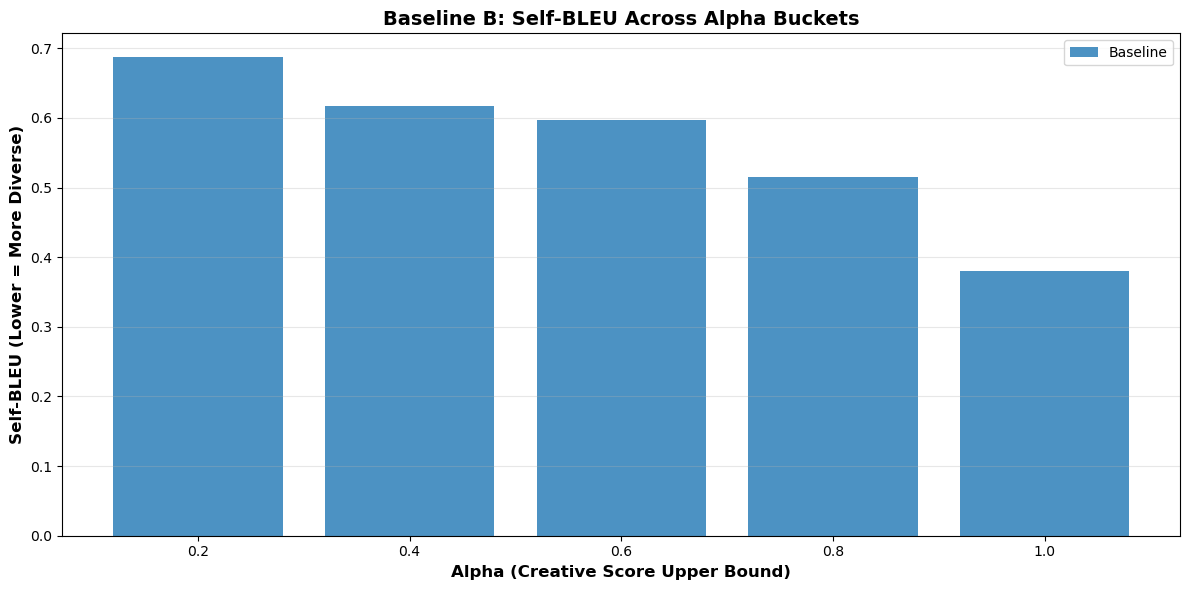

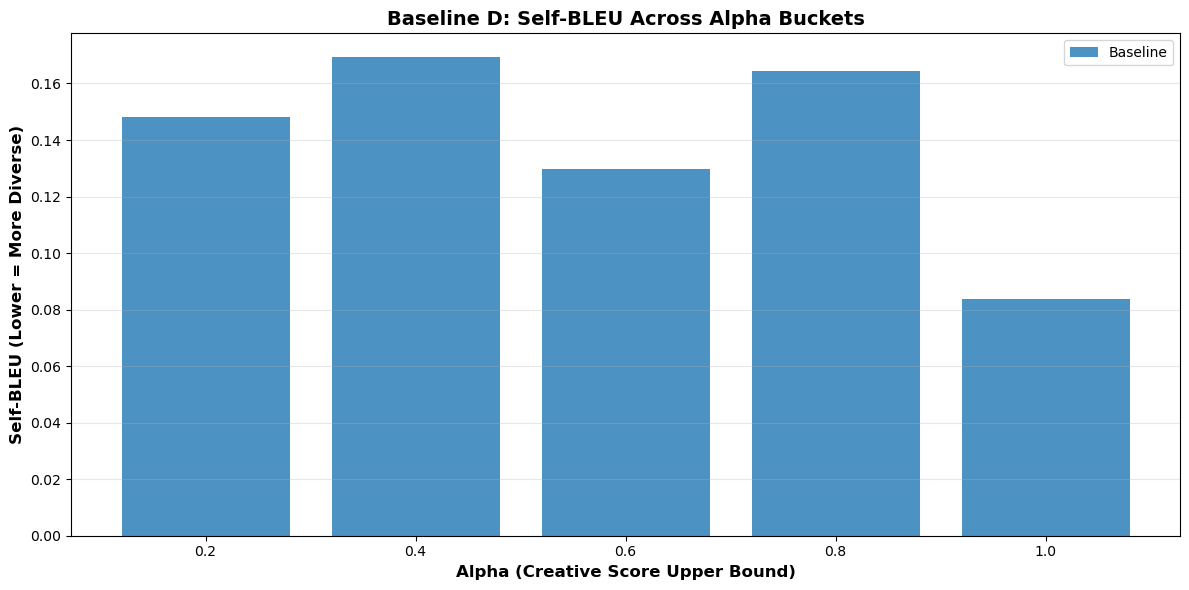

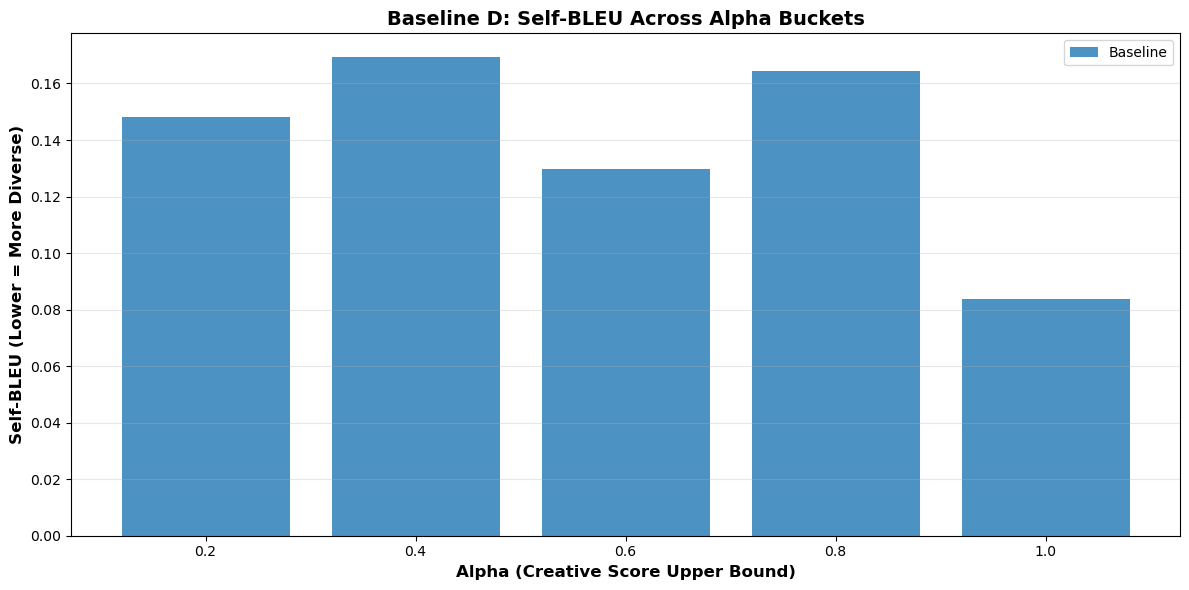

In [11]:
# Plot individually
plot_diversity_comparison(qwen_3_30b_baseline_b_results, 
                          title='Baseline B: Self-BLEU Across Alpha Buckets')
plot_diversity_comparison(qwen_3_30b_baseline_d_results, 
                          title='Baseline D: Self-BLEU Across Alpha Buckets')

In [12]:
!pip install sentence-transformers

  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl (8.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [sentence-transformers]ence-transformers]


In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Load model once (reuse across all calculations)
print("Loading embedding model...")
embedding_model = SentenceTransformer('all-mpnet-base-v2')
print("✅ Model loaded!")

def calculate_semantic_diversity(responses, model):
    """
    Calculate semantic diversity using sentence embeddings.
    
    Args:
        responses: List of response strings
        model: SentenceTransformer model
    
    Returns:
        float: Average pairwise cosine distance (0-2, higher = more diverse)
    """
    if len(responses) < 2:
        return 0.0
    
    # Generate embeddings
    embeddings = model.encode(responses, convert_to_numpy=True)
    
    # Calculate pairwise cosine distances
    distances = cosine_distances(embeddings)
    
    # Extract upper triangle (avoid diagonal and duplicates)
    n = len(responses)
    upper_triangle_indices = np.triu_indices(n, k=1)
    pairwise_distances = distances[upper_triangle_indices]
    
    # Return average distance
    return float(np.mean(pairwise_distances))

/Users/abhinavsattiraju/miniforge/envs/cs329x/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading embedding model...
✅ Model loaded!


In [14]:
def load_baseline_b_results_all_metrics(results_dir, embedding_model):
    """Load Baseline B with Self-BLEU, Distinct-2, and Semantic Diversity"""
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_b_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_b_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate all metrics
        self_bleu_scores = []
        distinct_2_scores = []
        semantic_div_scores = []
        malformed_count = 0
        
        for item in data:
            responses = item.get('responses', [])
            
            if not responses or not all(isinstance(r, str) and len(r.strip()) > 0 for r in responses):
                malformed_count += 1
                continue
            
            # Calculate metrics
            self_bleu_scores.append(calculate_self_bleu(responses))
            distinct_2_scores.append(calculate_distinct_n(responses, n=2))
            semantic_div_scores.append(calculate_semantic_diversity(responses, embedding_model))
        
        # Store averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'avg_semantic_div': np.mean(semantic_div_scores) if semantic_div_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}:")
        print(f"   Self-BLEU: {results[bucket_name]['avg_self_bleu']:.4f}, "
              f"Distinct-2: {results[bucket_name]['avg_distinct_2']:.4f}, "
              f"Semantic-Div: {results[bucket_name]['avg_semantic_div']:.4f}")
        print(f"   ({len(self_bleu_scores)}/{len(data)} prompts)")
    
    return results


def load_baseline_d_results_all_metrics(results_dir, embedding_model):
    """Load Baseline D with Self-BLEU, Distinct-2, and Semantic Diversity"""
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_d_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_d_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate all metrics
        self_bleu_scores = []
        distinct_2_scores = []
        semantic_div_scores = []
        malformed_count = 0
        parsing_errors = 0
        
        for item in data:
            answers = item.get('answers', [])
            
            if item.get('n_answers', 0) == 0:
                parsing_errors += 1
                continue
            
            if not answers or not all(isinstance(a, str) and len(a.strip()) > 0 for a in answers):
                malformed_count += 1
                continue
            
            # Calculate metrics
            self_bleu_scores.append(calculate_self_bleu(answers))
            distinct_2_scores.append(calculate_distinct_n(answers, n=2))
            semantic_div_scores.append(calculate_semantic_diversity(answers, embedding_model))
        
        # Store averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'avg_semantic_div': np.mean(semantic_div_scores) if semantic_div_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count,
            'parsing_errors': parsing_errors
        }
        
        status = "✅" if malformed_count == 0 else "⚠️ "
        print(f"{status} {bucket_name}:")
        print(f"   Self-BLEU: {results[bucket_name]['avg_self_bleu']:.4f}, "
              f"Distinct-2: {results[bucket_name]['avg_distinct_2']:.4f}, "
              f"Semantic-Div: {results[bucket_name]['avg_semantic_div']:.4f}")
        print(f"   ({len(self_bleu_scores)}/{len(data)} prompts)")
    
    return results

In [15]:
# Load results with ALL metrics
print("=" * 70)
print("LOADING BASELINE B RESULTS")
print("=" * 70)
baseline_b_results = load_baseline_b_results_all_metrics(
    'Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_b_results/',
    embedding_model
)

print("\n" + "=" * 70)
print("LOADING BASELINE D RESULTS")
print("=" * 70)
baseline_d_results = load_baseline_d_results_all_metrics(
    'Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_d_results/',
    embedding_model
)

LOADING BASELINE B RESULTS
✅ (-001.0, 0.2]:
   Self-BLEU: 0.6872, Distinct-2: 0.4845, Semantic-Div: 0.0535
   (100/100 prompts)
✅ (0.2, 0.4]:
   Self-BLEU: 0.6171, Distinct-2: 0.5644, Semantic-Div: 0.0755
   (100/100 prompts)
✅ (0.4, 0.6]:
   Self-BLEU: 0.5969, Distinct-2: 0.6023, Semantic-Div: 0.0684
   (100/100 prompts)
✅ (0.6, 0.8]:
   Self-BLEU: 0.5150, Distinct-2: 0.6806, Semantic-Div: 0.0964
   (100/100 prompts)
✅ (0.8, 1.0]:
   Self-BLEU: 0.3798, Distinct-2: 0.7736, Semantic-Div: 0.1442
   (100/100 prompts)

LOADING BASELINE D RESULTS
✅ (-001.0, 0.2]:
   Self-BLEU: 0.1481, Distinct-2: 0.6855, Semantic-Div: 0.2196
   (94/100 prompts)
✅ (0.2, 0.4]:
   Self-BLEU: 0.1693, Distinct-2: 0.7570, Semantic-Div: 0.2294
   (91/100 prompts)
⚠️  (0.4, 0.6]:
   Self-BLEU: 0.1296, Distinct-2: 0.8697, Semantic-Div: 0.2776
   (88/100 prompts)
✅ (0.6, 0.8]:
   Self-BLEU: 0.1645, Distinct-2: 0.8660, Semantic-Div: 0.2965
   (85/100 prompts)
✅ (0.8, 1.0]:
   Self-BLEU: 0.0836, Distinct-2: 0.9073, Sem

In [17]:
# ========================================
# LOAD INDIVIDUAL MODEL RESULTS (ALL METRICS)
# ========================================
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json

# ========================================
# PUBLICATION-QUALITY GROUPED BAR CHARTS
# ========================================

# Nice, muted colors for publication
COLORS = {
    'Qwen3-4B': '#5B9BD5',      # Soft blue
    'Qwen3-8B': '#ED7D31',       # Soft orange
    'Qwen3-30B': '#70AD47'       # Soft green
}

MODEL_DIRS = {
    'Qwen3-4B': 'Qwen/Qwen3-4B-Instruct-2507_baseline_X_results',
    'Qwen3-8B': 'Qwen/Qwen3-8B_baseline_X_results',
    'Qwen3-30B': 'Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_X_results'
}

def load_baseline_b_results_all_metrics(results_dir, embedding_model):
    """Load Baseline B with Self-BLEU, Distinct-2, and Semantic Diversity"""
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_b_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_b_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate all metrics
        self_bleu_scores = []
        distinct_2_scores = []
        semantic_div_scores = []
        malformed_count = 0
        
        for item in data:
            responses = item.get('responses', [])
            
            if not responses or not all(isinstance(r, str) and len(r.strip()) > 0 for r in responses):
                malformed_count += 1
                continue
            
            # Calculate metrics
            self_bleu_scores.append(calculate_self_bleu(responses))
            distinct_2_scores.append(calculate_distinct_n(responses, n=2))
            semantic_div_scores.append(calculate_semantic_diversity(responses, embedding_model))
        
        # Store averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'avg_semantic_div': np.mean(semantic_div_scores) if semantic_div_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count
        }
    
    return results


def load_baseline_d_results_all_metrics(results_dir, embedding_model):
    """Load Baseline D with Self-BLEU, Distinct-2, and Semantic Diversity"""
    bucket_files = glob.glob(os.path.join(results_dir, "baseline_d_*.json"))
    bucket_files = [f for f in bucket_files if 'summary' not in f]
    
    results = {}
    
    for filepath in sorted(bucket_files):
        filename = os.path.basename(filepath)
        bucket_str = filename.replace('baseline_d_', '').replace('.json', '')
        parts = bucket_str.split('_')
        
        # Reconstruct bucket name
        if len(parts) >= 4:
            left = f"-{parts[1]}.{parts[2]}" if parts[0] == '-0' else f"{parts[0]}.{parts[1]}"
            right = f"{parts[2]}.{parts[3]}"
            bucket_name = f"({left}, {right}]"
        else:
            bucket_name = bucket_str
        
        # Load data
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Calculate all metrics
        self_bleu_scores = []
        distinct_2_scores = []
        semantic_div_scores = []
        malformed_count = 0
        parsing_errors = 0
        
        for item in data:
            answers = item.get('answers', [])
            
            if item.get('n_answers', 0) == 0:
                parsing_errors += 1
                continue
            
            if not answers or not all(isinstance(a, str) and len(a.strip()) > 0 for a in answers):
                malformed_count += 1
                continue
            
            # Calculate metrics
            self_bleu_scores.append(calculate_self_bleu(answers))
            distinct_2_scores.append(calculate_distinct_n(answers, n=2))
            semantic_div_scores.append(calculate_semantic_diversity(answers, embedding_model))
        
        # Store averages
        results[bucket_name] = {
            'avg_self_bleu': np.mean(self_bleu_scores) if self_bleu_scores else 0.0,
            'avg_distinct_2': np.mean(distinct_2_scores) if distinct_2_scores else 0.0,
            'avg_semantic_div': np.mean(semantic_div_scores) if semantic_div_scores else 0.0,
            'n_prompts': len(data),
            'successful_evals': len(self_bleu_scores),
            'malformed_count': malformed_count,
            'parsing_errors': parsing_errors
        }
    
    return results


# ========================================
# LOAD ALL 3 MODELS FOR ONE BASELINE
# ========================================

def load_all_models_baseline_results(baseline_type, embedding_model):
    """
    Load results for all 3 models for a given baseline (B or D)
    
    Args:
        baseline_type: 'b' or 'd'
        embedding_model: SentenceTransformer model for semantic diversity
    
    Returns:
        Dict of {model_name: {bucket: {metrics}}}
        
    Example output structure:
    {
        'Qwen3-4B': {
            '(-0.001, 0.2]': {'avg_self_bleu': 0.15, 'avg_distinct_2': 0.85, ...},
            '(0.2, 0.4]': {...},
            ...
        },
        'Qwen3-8B': {...},
        'Qwen3-30B': {...}
    }
    """
    all_models = {}
    
    for model_name, dir_template in MODEL_DIRS.items():
        # Replace 'baseline_X' with 'baseline_b' or 'baseline_d'
        results_dir = dir_template.replace('baseline_X', f'baseline_{baseline_type}')
        
        if not os.path.exists(results_dir):
            print(f"⚠️  {results_dir} not found, skipping {model_name}")
            continue
        
        print(f"Loading {model_name} Baseline {baseline_type.upper()}...")
        
        # Call appropriate loader function
        if baseline_type == 'b':
            model_results = load_baseline_b_results_all_metrics(results_dir, embedding_model)
        else:  # baseline_type == 'd'
            model_results = load_baseline_d_results_all_metrics(results_dir, embedding_model)
        
        all_models[model_name] = model_results
    
    return all_models

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json

# ========================================
# PUBLICATION-QUALITY GROUPED BAR CHARTS
# ========================================

# Nice, muted colors for publication
COLORS = {
    'Qwen3-4B': '#5B9BD5',      # Soft blue
    'Qwen3-8B': '#ED7D31',       # Soft orange
    'Qwen3-30B': '#70AD47'       # Soft green
}

MODEL_DIRS = {
    'Qwen3-4B': 'Qwen/Qwen3-4B-Instruct-2507_baseline_X_results',
    'Qwen3-8B': 'Qwen/Qwen3-8B_baseline_X_results',
    'Qwen3-30B': 'Qwen/Qwen3-30B-A3B-Instruct-2507_baseline_X_results'
}


def load_all_models_baseline_results(baseline_type, embedding_model):
    """
    Load results for all 3 models for a given baseline (B or D)
    
    Args:
        baseline_type: 'b' or 'd'
        embedding_model: SentenceTransformer model for semantic diversity
    
    Returns:
        Dict of {model_name: {bucket: {metrics}}}
    """
    all_models = {}
    
    for model_name, dir_template in MODEL_DIRS.items():
        results_dir = dir_template.replace('baseline_X', f'baseline_{baseline_type}')
        
        if not os.path.exists(results_dir):
            print(f"⚠️  {results_dir} not found, skipping {model_name}")
            continue
        
        print(f"Loading {model_name} Baseline {baseline_type.upper()}...")
        
        if baseline_type == 'b':
            model_results = load_baseline_b_results_all_metrics(results_dir, embedding_model)
        else:
            model_results = load_baseline_d_results_all_metrics(results_dir, embedding_model)
        
        all_models[model_name] = model_results
    
    return all_models


def plot_grouped_bar_chart(all_models_data, metric_key, baseline_name, 
                           ylabel, title, figsize=(14, 6)):
    """
    Create grouped bar chart with 3 models per bucket
    
    Args:
        all_models_data: Dict of {model_name: {bucket: {metric_key: value}}}
        metric_key: Which metric to plot
        baseline_name: 'Baseline B' or 'Baseline D'
        ylabel: Y-axis label
        title: Plot title
    """
    # Get buckets (assume all models have same buckets)
    first_model = next(iter(all_models_data.values()))
    buckets = sorted(first_model.keys(), 
                     key=lambda x: float(x.split(',')[1].strip('] ')))
    
    bucket_labels = []
    for bucket in buckets:
        left = bucket.split(',')[0].strip('(')
        right = bucket.split(',')[1].strip('] ')
        
        # Convert any negative or near-zero values to "0.0"
        left_float = float(left)
        if left_float < 0.01:  # Catches -0.001, 0.0, etc.
            left = '0.0'
        
        bucket_labels.append(f"{left}-{right}")
    
    # Set up plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Bar positioning
    n_models = len(all_models_data)
    n_buckets = len(buckets)
    x = np.arange(n_buckets)
    width = 0.25  # Width of each bar
    
    # Plot bars for each model
    for i, (model_name, model_data) in enumerate(all_models_data.items()):
        values = [model_data[bucket][metric_key] for bucket in buckets]
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(x + offset, values, width, 
               label=model_name, 
               color=COLORS[model_name],
               alpha=0.85,
               edgecolor='white',
               linewidth=1.2)
    
    # Formatting
    ax.set_xlabel('Creativity Score Bins', fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(bucket_labels, fontsize=11)
    ax.legend(fontsize=11, framealpha=0.95, edgecolor='gray')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Load embedding model (for semantic diversity)
# from sentence_transformers import SentenceTransformer
# embedding_model = SentenceTransformer('all-mpnet-base-v2')

# # Load all data
# print("=" * 70)
# print("LOADING ALL MODEL RESULTS")
# print("=" * 70)
# baseline_b_all = load_all_models_baseline_results('b', embedding_model)
# baseline_d_all = load_all_models_baseline_results('d', embedding_model)

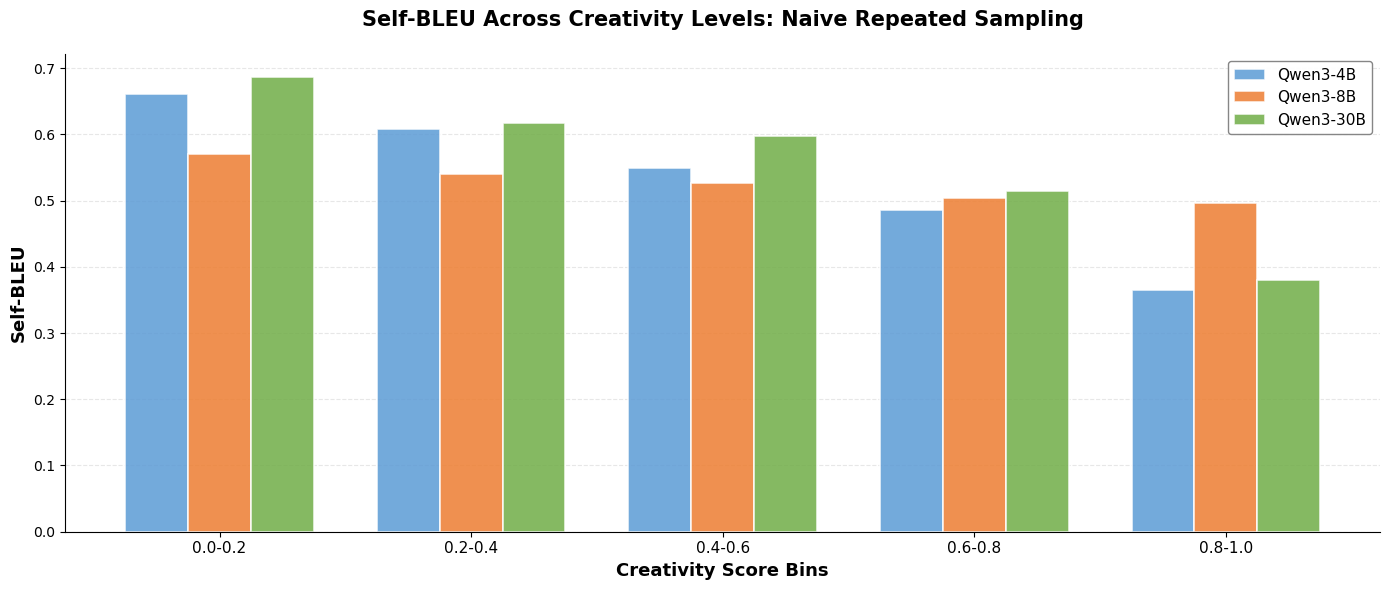

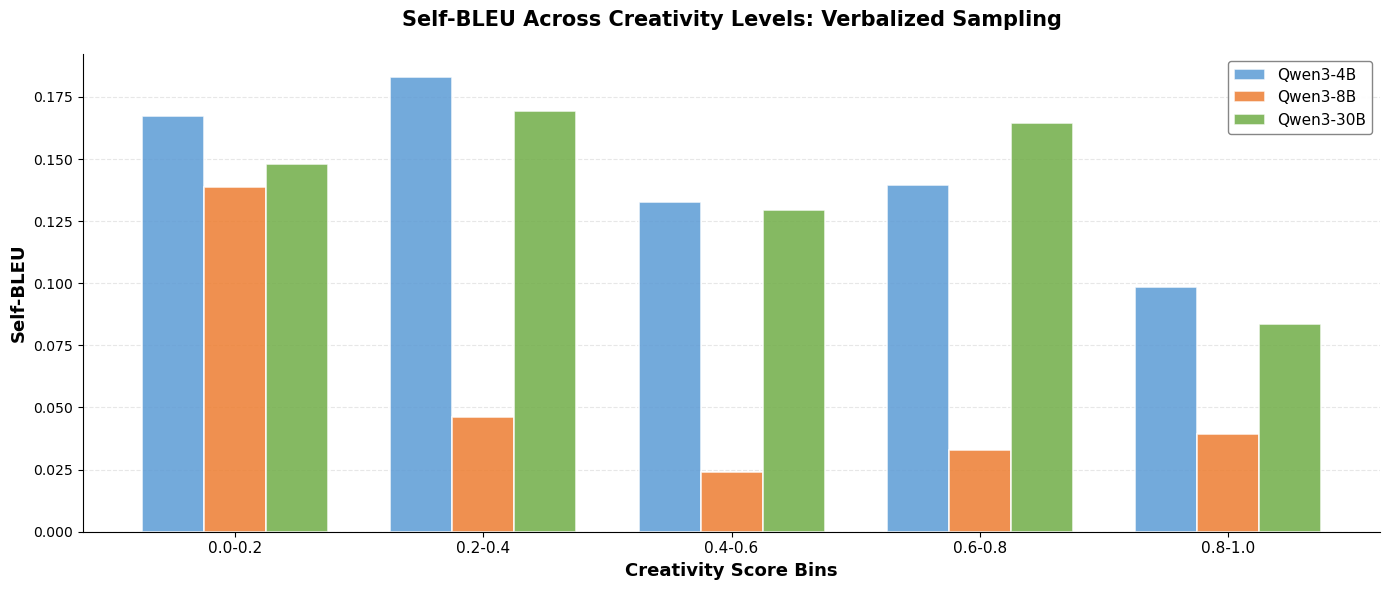

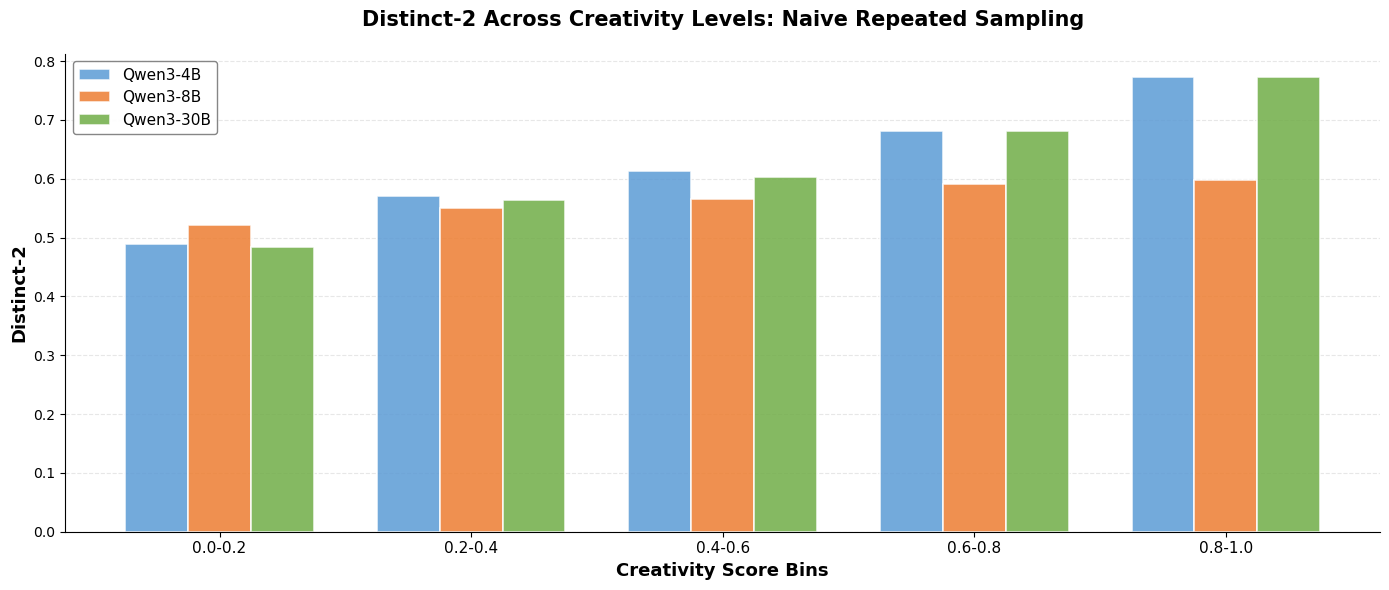

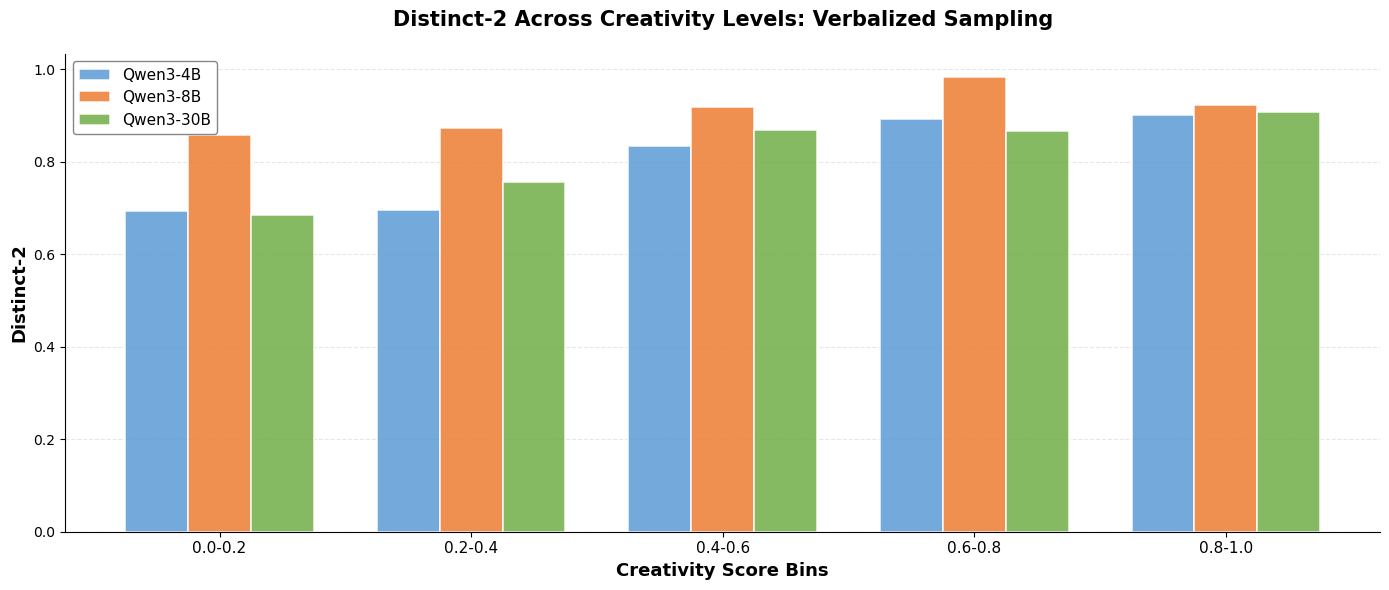

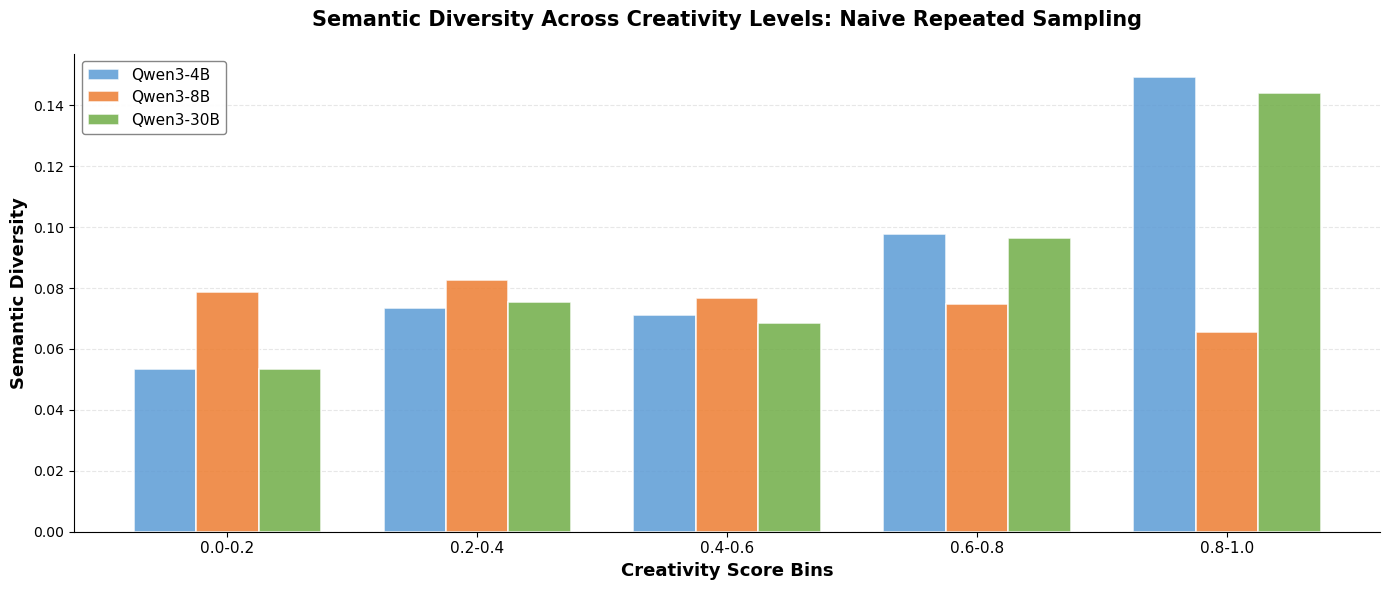

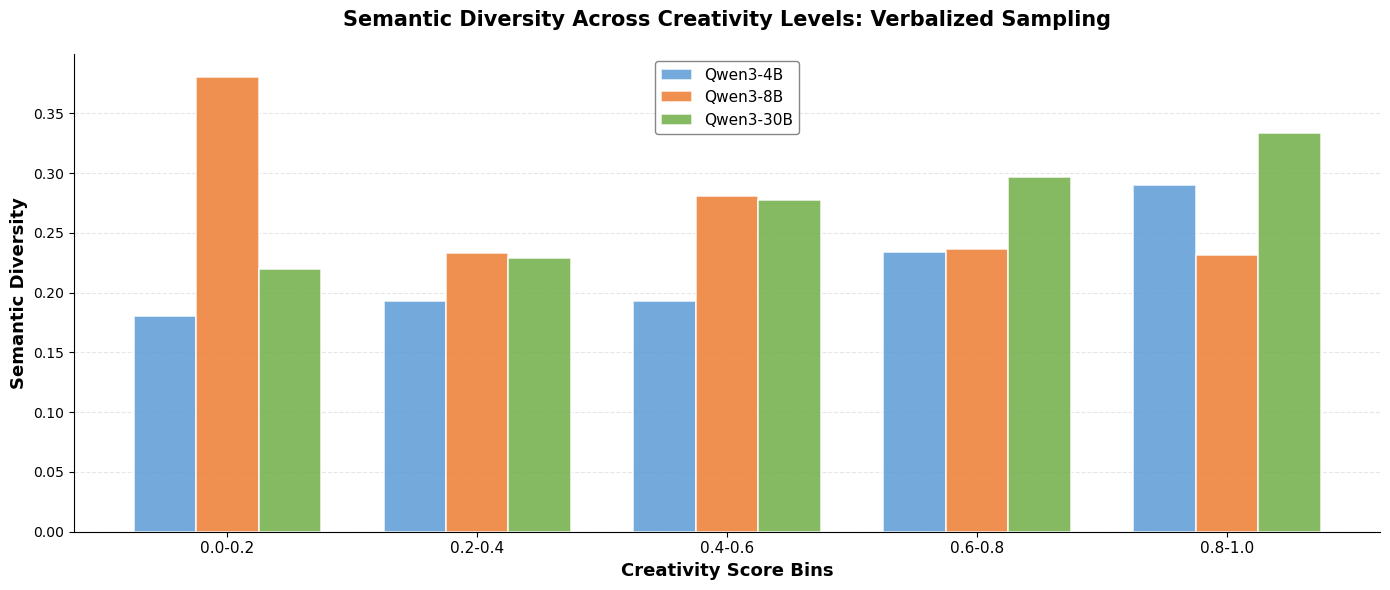


✅ All 6 plots generated!


In [27]:
# ========================================
# PLOT 1 & 2: SELF-BLEU
# ========================================

plot_grouped_bar_chart(
    baseline_b_all,
    metric_key='avg_self_bleu',
    baseline_name='Baseline B',
    ylabel='Self-BLEU',
    title='Self-BLEU Across Creativity Levels: Naive Repeated Sampling'
)

plot_grouped_bar_chart(
    baseline_d_all,
    metric_key='avg_self_bleu',
    baseline_name='Baseline D',
    ylabel='Self-BLEU',
    title='Self-BLEU Across Creativity Levels: Verbalized Sampling'
)

# ========================================
# PLOT 3 & 4: DISTINCT-2
# ========================================

plot_grouped_bar_chart(
    baseline_b_all,
    metric_key='avg_distinct_2',
    baseline_name='Baseline B',
    ylabel='Distinct-2',
    title='Distinct-2 Across Creativity Levels: Naive Repeated Sampling'
)

plot_grouped_bar_chart(
    baseline_d_all,
    metric_key='avg_distinct_2',
    baseline_name='Baseline D',
    ylabel='Distinct-2',
    title='Distinct-2 Across Creativity Levels: Verbalized Sampling'
)

# ========================================
# PLOT 5 & 6: SEMANTIC DIVERSITY
# ========================================

plot_grouped_bar_chart(
    baseline_b_all,
    metric_key='avg_semantic_div',
    baseline_name='Baseline B',
    ylabel='Semantic Diversity',
    title='Semantic Diversity Across Creativity Levels: Naive Repeated Sampling'
)

plot_grouped_bar_chart(
    baseline_d_all,
    metric_key='avg_semantic_div',
    baseline_name='Baseline D',
    ylabel='Semantic Diversity',
    title='Semantic Diversity Across Creativity Levels: Verbalized Sampling'
)

print("\n✅ All 6 plots generated!")